In [248]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import scipy.stats as stats
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV

# objective of the project


*The objective of this project is to develop a machine learning model that can predict the inmersion level of an individua based on relevant features such as age, duration of
use, and other factors using the ”vr dataset” dataset.*



This project is focused on building machine learning classifiers to predict the level of immersion based on various features. 
 
- The project is divided into two parts:

    - *ML_part_1.ipynb*: The goal is to generate a classifier to predict the immersion level on a scale from 1 to 5. The classifier used is a Random Forest Classifier. 
    However, the model performance on this dataset is poor, there are several reasons that may affect this issue some of these will be analyzed and discussed during the code development.

    - *ML_part_2.ipynb*: Given the poor performance in part one, the problem is simplified. Instead of predicting a specific immersion level, the classifier will predict whether the immersion level is "good" or "bad". Additionally, feature selection techniques will be applied to select different types of features to make the data easier to learn.

# TASK 1 : Data Exploration and Preprocessing

# TASK 1.1 
*Load the ”vr dataset” dataset.*


In [249]:
#Download the dataset
dataframe = pd.read_csv('vr_dataset.csv', delimiter=',')

#Get the shape of the dataset
(N_records, N_features) = dataframe.shape

#Print the first 5 rows of the dataset
print(f'\n\nFIRST 5 ROWS OF THE DATASET\n\n{dataframe.head().round(2)}')

#Print general description of the dataset
print(f'\n\nDESCRIPTION OF THE DATASET\n\n{dataframe.describe().round(2)}') 



FIRST 5 ROWS OF THE DATASET

   UserID  Age  Gender       VRHeadset  Duration  MotionSickness  \
0       1   40    Male        HTC Vive     13.60               8   
1       2   43  Female        HTC Vive     19.95               2   
2       3   27    Male  PlayStation VR     16.54               4   
3       4   33    Male        HTC Vive     42.57               6   
4       5   51    Male  PlayStation VR     22.45               4   

   ImmersionLevel  
0               5  
1               2  
2               2  
3               3  
4               2  


DESCRIPTION OF THE DATASET

        UserID      Age  Duration  MotionSickness  ImmersionLevel
count  1000.00  1000.00   1000.00         1000.00         1000.00
mean    500.50    39.18     32.58            5.53            2.98
std     288.82    12.05     15.76            2.87            1.41
min       1.00    18.00      5.01            1.00            1.00
25%     250.75    29.00     18.73            3.00            2.00
50%     500.50

# TASK 1.2 
*Handle any missing values, if present.*

In [250]:
#Check for missing values 
stats = []
for col in dataframe.columns:
    stats.append([col, dataframe[col].nunique(), dataframe[col].isnull().sum(), dataframe[col].dtype])
    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Missing_values', 'Data_type'])
print(f'\n\nSTATISTICS OF THE DATASET\n\n{tabulate(stats_df, headers="keys", tablefmt="pretty")}')



STATISTICS OF THE DATASET

+---+----------------+---------------+----------------+-----------+
|   |    Feature     | Unique_values | Missing_values | Data_type |
+---+----------------+---------------+----------------+-----------+
| 0 |     UserID     |     1000      |       0        |   int64   |
| 1 |      Age       |      43       |       0        |   int64   |
| 2 |     Gender     |       3       |       0        |  object   |
| 3 |   VRHeadset    |       3       |       0        |  object   |
| 4 |    Duration    |     1000      |       0        |  float64  |
| 5 | MotionSickness |      10       |       0        |   int64   |
| 6 | ImmersionLevel |       5       |       0        |   int64   |
+---+----------------+---------------+----------------+-----------+




To accomplish this task we can plot the statistics of the dataset.

As shown in the table, there are **no missing values** in the dataset. 

The dataset contains 7 features one of which is the target class, regarding this features we can state the following:

- **Categorical features**: 
    - *Gender*
    - *VRHeadset*

- **Numerical features**: 
    - *Age*
    - *Duration*
    - *MotionSickness*

- **ImmersionLevel** This feature is the target class, the information of this feature is discrete sequance of 5 unique values: 1, 2, 3, 4, 5.

- **User ID** This column of data does not contain any valuable information about the dataset since it is only used to distinguish between users and there is no repetition of them in the dataset, for this reason this feature is not taken into account when training the model.


*Handle any outliers, if present.*

The boxplot is used to visually inspect the distribution of the numerical features in the dataset, particularly focusing on spotting outliers.

Boxplots are effective for this purpose because they show the median, quartiles, and outliers for each feature. 

In this specific case there isn't any outlier.

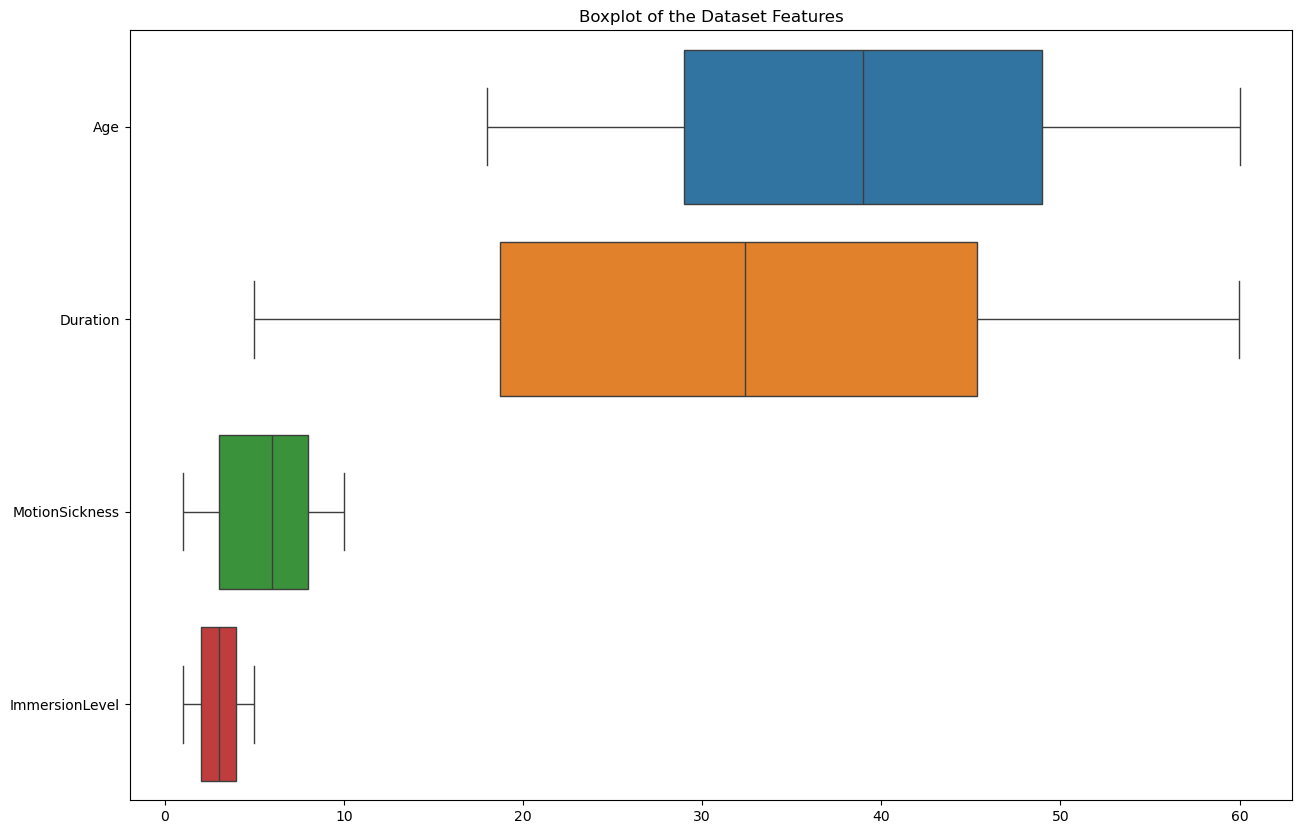

In [251]:
#Check for outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=dataframe.drop('UserID', axis=1), orient='h')
plt.title('Boxplot of the Dataset Features')
plt.show()

# Task 1.2

*Visualize the distribution of the ”Age” and ”VRHeadset" variables using appropriate plots (e.g., histograms scatter plots)*

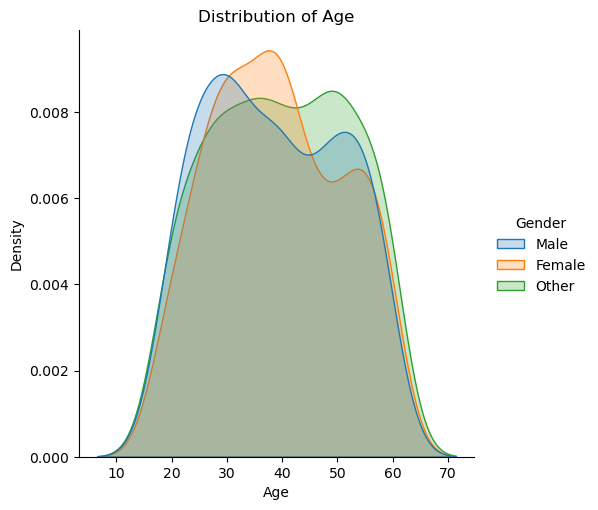

In [252]:
#Visualize the distribution of the "Age" variable
sns.displot(dataframe, x="Age", hue="Gender", kind="kde",fill=True, legend=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

This plot is used to visualize how the ages are distributed across the dataset, with the KDE plot providing a smooth estimate of the distribution separated by gender.

Note that the distibution are almost uniformly distributed in the interval 18-60. This indicates that our dataset is balanced with respect the age and the gender.

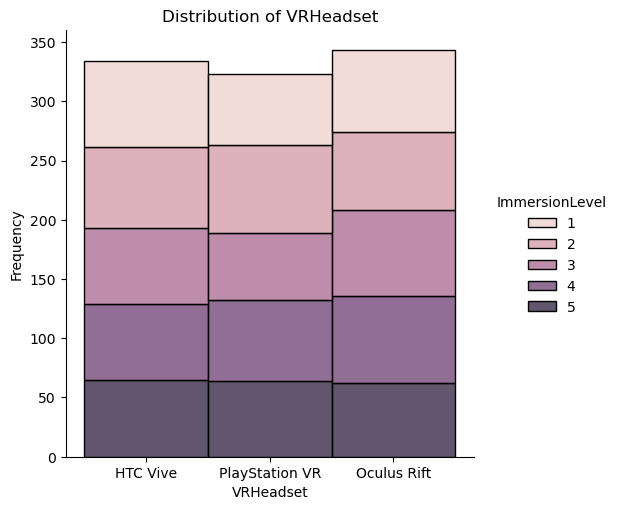

In [253]:
sns.displot(dataframe, x="VRHeadset", hue="ImmersionLevel", multiple="stack", kind="hist", legend=True)   
plt.title('Distribution of VRHeadset')
plt.xlabel('VRHeadset')
plt.ylabel('Frequency')
plt.show()

This plot generates a stacked histogram that visualizes the distribution of VR Headset.
these bars are divided into segments based on the ImmersionLevel. The segments within each bar show the frequency of each immersion level within the specific category of VR headset. Note that the type of VR Headset does not directly affect the Immersion Level.

*Let's see if our dataset is balanced with respect to the target feature Immersion level.*

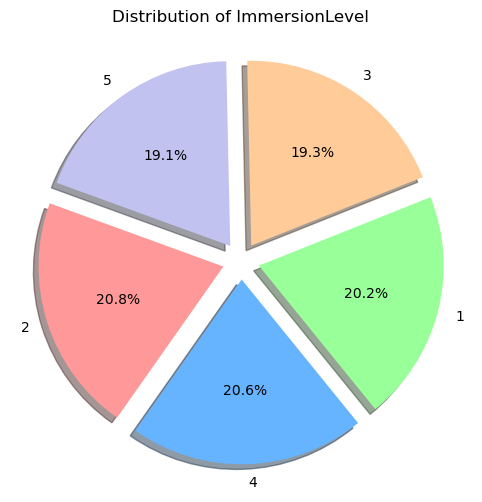

In [254]:
plt.figure(figsize=(10, 6))
plt.pie(dataframe['ImmersionLevel'].value_counts(), labels=dataframe['ImmersionLevel'].value_counts().index, autopct='%1.1f%%', shadow=True, startangle=160, explode=(0.1, 0.1,0.1,0.1,0.1), colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0'])
plt.title('Distribution of ImmersionLevel')
plt.show()

As we can see the target feature is balanced therefore from this point of view we do not need to modify the dataset.

# TASK 2 : Feature Selection and Engineering

# TASK 2.1

*Identify the relevant features from the dataset that can potentially influence immersion level prediction.*

Let's visulize how our dataset is correlated.

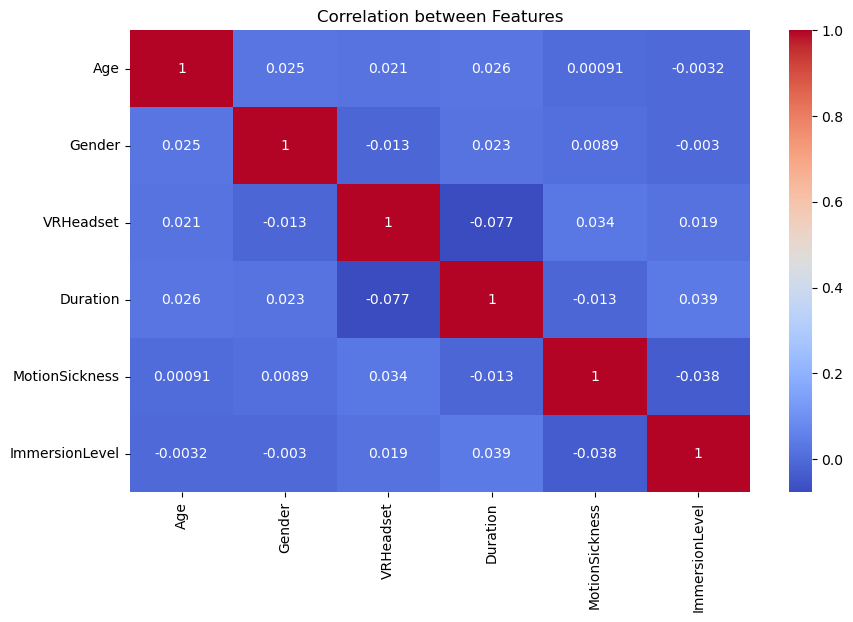

In [255]:
# Convert categorical variables into numerical variables
df = dataframe.copy()
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df['VRHeadset'] = label_encoder.fit_transform(df['VRHeadset'])

# Visualize the correlation between features
correlation_matrix = df.drop(['UserID'], axis=1).corr(),
plt.figure(figsize=(10, 6))
sns.heatmap(df.drop(['UserID'], axis=1).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between Features')
plt.show()


The correlation matrix shows that for each feature there is no linear correlation with any other feature in the dataset. This scenario suggests that the features are linearly independent between each other.

Bivariate distributions are useful for analyzing relationships between two variables in a dataset also when the relationship of the two variables are non-linear like in our case.


- **Interpretation of Bivariate Distributions**

    - *Linear Patterns*: If the points follow a straight line, there is a linear relationship between the variables.
    - *Non-Linear Patterns*: If the points follow a curve, there is a non-linear relationship.
    - *Clusters*: Groups of points indicate that there may be distinct subgroups in the dataset.
    - *Outliers*: Points far from the general pattern indicate anomalies or outliers.

- **Interpretation of the boxplot**

    - *Central Tendency*: The line inside the box shows the median of the data.
    - *Interquartile Range*: The box itself represents the middle 50% of the data, from the first quartile to the third quartile.
    - *Spread*: The line that pass trough the box shows where the range in which the data is spread.

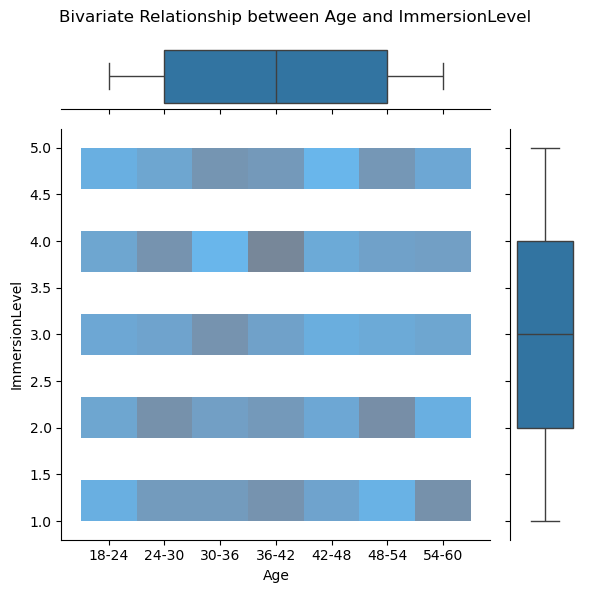

In [256]:
# Group the age in intervals 
df = dataframe.copy()
df['Age'] = pd.cut(df['Age'], bins=[18, 24, 30, 36, 42, 48, 54, 60], labels=['18-24', '24-30', '30-36', '36-42', '42-48', '48-54', '54-60'])

# Visualize the Bivariate relationship between the "Age" and "ImmersionLevel" variables
g = sns.JointGrid(data=df, x="Age", y="ImmersionLevel")
g.plot_joint(sns.histplot, bins=9, alpha=0.7)
g.plot_marginals(sns.boxplot)
plt.xlabel('Age')
plt.ylabel('ImmersionLevel')
plt.suptitle('Bivariate Relationship between Age and ImmersionLevel')
plt.tight_layout()
plt.show()

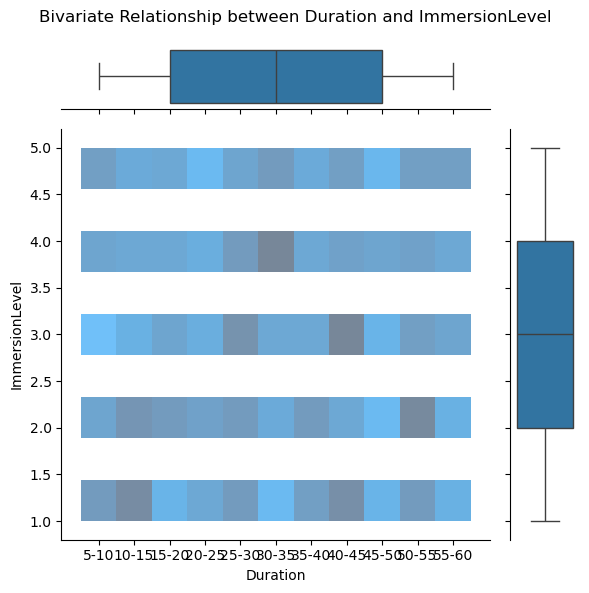

In [257]:
# Group the duration in intervals
df = dataframe.copy()
df['Duration'] = pd.cut(df['Duration'], bins=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], labels=['5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60']) 

# Visualize the Bivariate relationship between the "Duration" and "ImmersionLevel" variables
g = sns.JointGrid(data=df, x="Duration", y="ImmersionLevel", space=0)
g.plot_joint(sns.histplot, bins=9, alpha=0.7)
g.plot_marginals(sns.boxplot)
plt.xlabel('Duration')
plt.ylabel('ImmersionLevel')
plt.suptitle('Bivariate Relationship between Duration and ImmersionLevel')
plt.tight_layout()
plt.show()

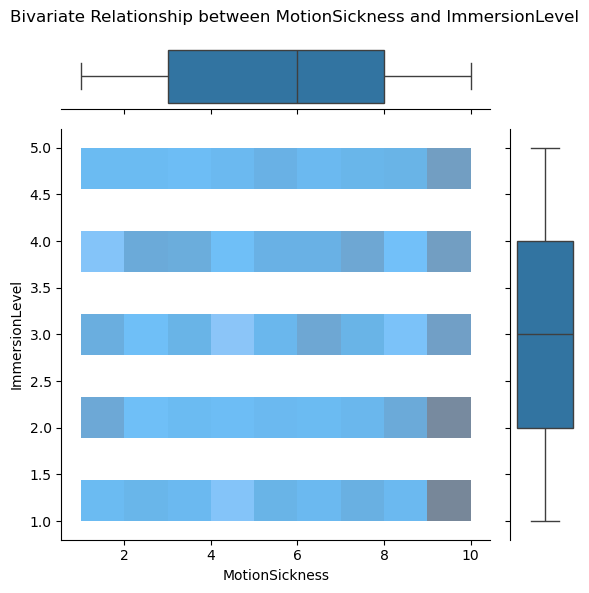

In [258]:
# Visualize the Bivariate relationship between the "MotionSickness" and "ImmersionLevel" variables
g = sns.JointGrid(data=dataframe, x="MotionSickness", y="ImmersionLevel", space=0)
g.plot_joint(sns.histplot, bins=9, alpha=0.7)
g.plot_marginals(sns.boxplot)
plt.xlabel('MotionSickness')
plt.ylabel('ImmersionLevel')
plt.suptitle('Bivariate Relationship between MotionSickness and ImmersionLevel')
plt.tight_layout()
plt.show()

The shown graphs, does not capture any particular shape, we can see a slight tendency to have high values of motion sickness but this is indipendent to the value of immersion level.

The poorness of the visualization to capture any non-linear shape may be due to the fact that the dimension of the dataset is too little to appriciate any tendency of the immersion level.

One other problem that may cause this issue is that the generation of the dataset is inconsistent with respect its evaluation metrics, for this reason one may conclude that it is difficult to predict the exact value of the immersion level, but it may be possible to evaluate "good" and "bad" immersion levels.

Let's see how the categorical variables affect the target feature.

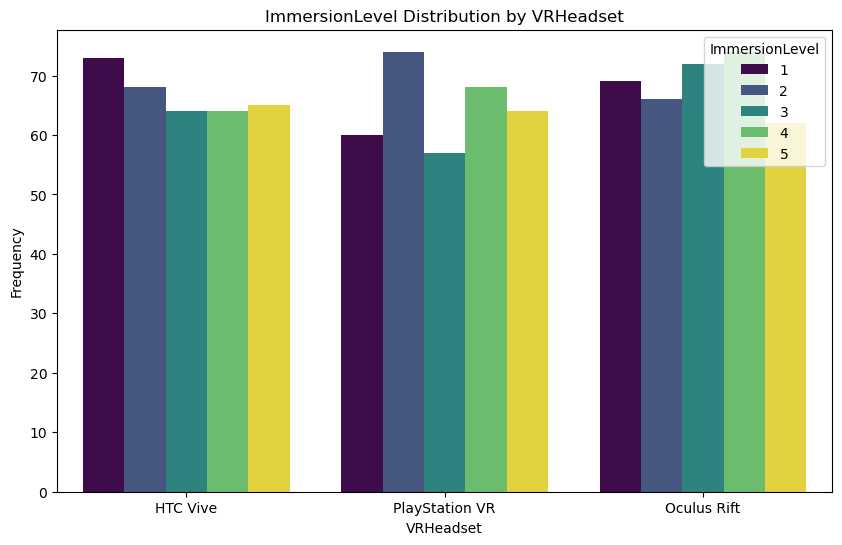

In [259]:
# Countplot of the "ImmersionLevel" variable with respect to VRHeadset
plt.figure(figsize=(10, 6))
sns.countplot(data=dataframe, x='VRHeadset', hue='ImmersionLevel', palette='viridis')
plt.title('ImmersionLevel Distribution by VRHeadset')
plt.xlabel('VRHeadset')
plt.ylabel('Frequency')
plt.show()

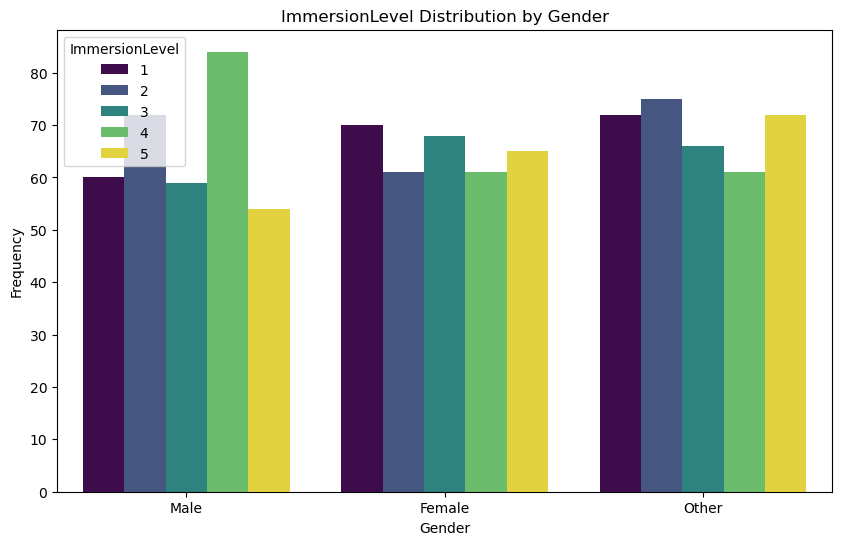

In [260]:
# Countplot of the "ImmersionLevel" variable with respect to the Gender
plt.figure(figsize=(10, 6))
sns.countplot(data=dataframe, x='Gender', hue='ImmersionLevel', palette='viridis')
plt.title('ImmersionLevel Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.show()

For what we have seen so far none of the variables considerably affect directly the target features. 
The relationship between the variables might be non-linear and not easily discernible in a simple plot. One solution for this type of problem may be to apply a non-linear model like decision trees or random forest to explore potential relationships. 
After this models are trained it is possible to visualize which are the relevant features and how much they affect in the classification problem.

# TASK 2.2

*Perform feature engineering, if necessary, such as scaling or transforming features.*

This lines of code split the dataset in traing set and test set, and apply the transforms necessary to the algorithm to work. 

In particular this transformer "One-hot encoder" is used in data preprocessing to convert categorical variables into a form that could be provided to ML algorithms to do a better job in prediction.

In [261]:
# The selected features are: Age, Duration, MotionSickness, Note that these features are categorical
features = ['Age', 'Duration', 'MotionSickness', 'VRHeadset', 'Gender'] # IF YOU WANT TO REMOVE SOME FEATURES, REMOVE THEM HERE

# The target feature is ImmersionLevel
target = 'ImmersionLevel'

# Split the dataset into features and target
X = dataframe[features]
y = dataframe[target]

# One-hot encode the categorical features
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [3, 4])], remainder='passthrough')

# TASK 3 : Model Development and Evaluation

# TASK 3.1-3.2

*Choose an appropriate machine learning algorithm (e.g., linear regression,decision tree regression, or random forest regression)to train the model.*

As already discussed we will try to use a random forest classifier **OR** a decision tree classifier, this problem cannot be adressed to a regressor.

The main diffrence between the two models is that random forest is less prone to overfitt the data.

There is not a clear winner between the two models but the Random Forest Classifier **has a slight edge over the Decision Tree Classifier** fill free to change this selection.

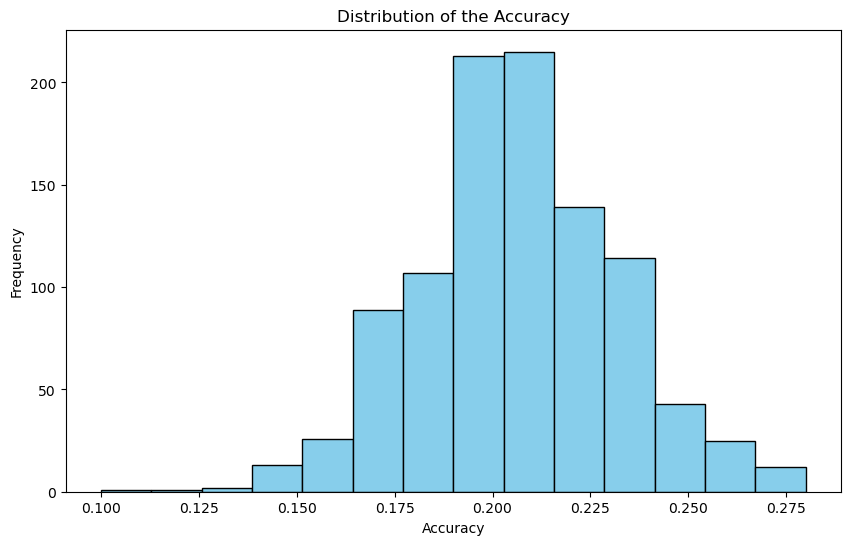


The best model parameters are the following:

The most relevant features for decision tree classifier are the following
encoder__VRHeadset_HTC Vive: 2.46%
encoder__VRHeadset_Oculus Rift: 2.42%
encoder__VRHeadset_PlayStation VR: 2.40%
encoder__Gender_Female: 2.45%
encoder__Gender_Male: 2.23%
encoder__Gender_Other: 2.50%
remainder__Age: 30.39%
remainder__Duration: 37.13%
remainder__MotionSickness: 18.02%


In [262]:
# choose a model to train among the two models, 
if True:
    rf = RandomForestClassifier()
    param_grid =param_grid = {
                            'n_estimators': [50, 100, 150],
                            'max_depth': [10, 20, 30, 40, 50],
                            'min_samples_split': [2, 5, 10],
                            'min_samples_leaf': [1, 2, 4]
                            }
else:
    rf = DecisionTreeClassifier()
    param_grid = {
                            'max_depth': [10, 20, 30, 40, 50],
                            'min_samples_split': [2, 5, 10],
                            'min_samples_leaf': [1, 2, 4]
                        }

dim = 1000
accuracy = np.zeros(dim)
models =[]
for ii in range(dim):
    # Split the dataset into training and testing subsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Fit the ColumnTransformer
    X_train = ct.fit_transform(X_train)
    X_test = ct.transform(X_test)

    # Store the feature names
    feature_names = ct.get_feature_names_out()

    # Predict the target variable
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Evaluate the model
    accuracy[ii] = rf.score(X_test, y_test)

    # Save the model
    models.append(rf)

# Plot the distribution of the accuracy
plt.figure(figsize=(10, 6))
plt.hist(accuracy, bins=14, color='skyblue', edgecolor='black')
plt.title('Distribution of the Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()

# select the best model
best_model = models[np.argmax(accuracy)]

# Print the best model parameters
print(f'\nThe best model parameters are the following:')
rf = best_model
print(f'\nThe most relevant features for decision tree classifier are the following')
for i in range(len(feature_names)):
    print(f'{feature_names[i]}: {rf.feature_importances_[i]*100:.2f}%')


This table shows that the type of headset and the gender does not considerably affect the immersion level, one may consider to remove these features from the dataset. 

Since the dataset is not really big in the number of observations and its dimensionality I decide to keep these informations and to not remove these them, but if you want to try you can change this decision in the previous step.

I can guarantee that the removal of these two features does not improve the quality of the gerated classifier.

# IMPORTANT

# Model Accuracy Analysis


The accuracy of the model is approximately 20%. This value is derived from the formula 1/{unique values of the target class} * 100.

Essentially, this indicates that the model's predictions are as accurate as simply predicting the most frequent target class for all observations.


To illustrate this, we will create a classifier that predicts the most common immersion level for every sample in the test set.


Analyzing the accuracy of a single model does not provide sufficient qualitative information about the prediction capabilities of the algorithm. Therefore, I have plotted the accuracy distribution of the classifier using different datasets. This approach allows us to observe whether there is a consistent tendency of the algorithm to perform better than the "most common" predictor, which, in this specific case, a random predictor.

By comparing these distributions, we can gain a more qualitative understanding of the algorithm's performance. Specifically, we can determine if the algorithm can recognize patterns in the dataset that lead to a generalization of the rule for deciding the immersion level.


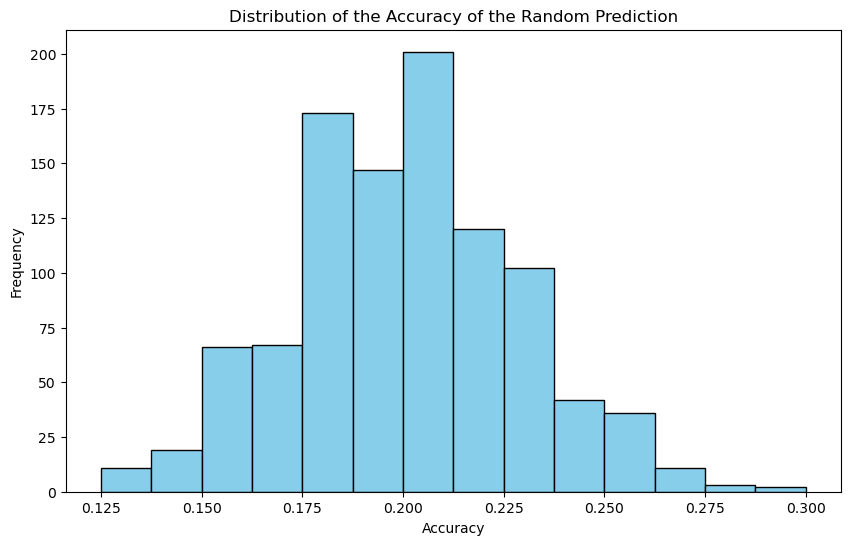

In [285]:
# Compute the accuracy of the random prediction
accuracy_random = np.zeros(dim)
for k in range(dim):
    y_pred_random = np.random.choice(y_test, len(y_test))
    
    accuracy_random[k] = rf.score(X_test, y_pred_random)
    
# Plot the distribution of the accuracy of the random prediction
plt.figure(figsize=(10, 6))
plt.hist(accuracy_random, bins=14, color='skyblue', edgecolor='black')
plt.title('Distribution of the Accuracy of the Random Prediction')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()

If one compers the two distribution it is possible to see that the accuracy distribution of the Random search tree is slightly better then the random predictor as the mean of the distribution tends to go over the 20% with less variance.

# TASK 3.3
*Fine-tune the model, if required, by adjusting hyperparameters to improve performance.*

Let'see if optimize/tuning the model can improve its performance.

In [270]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f'\n\nBest hyperparameters: {grid_search.best_params_}')



Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}


# TASK 4 : Prediction and Interpretation

# TASK 4.1

*Use the trained model to make predictions on the testing data.*

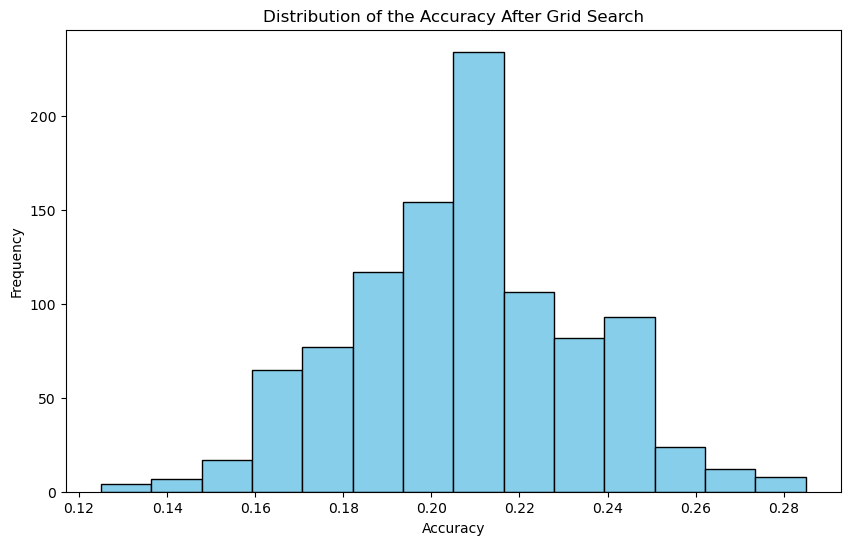

In [274]:
accuracy_tuned = np.zeros(dim)
for ii in range(dim):
    # Split the dataset into training and testing subsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Fit the ColumnTransformer
    X_train = ct.fit_transform(X_train)
    X_test = ct.transform(X_test)

    # Store the feature names
    feature_names = ct.get_feature_names_out()

    # Predict the target variable
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Evaluate the model
    accuracy_tuned[ii] = rf.score(X_test, y_test)

    # Save the model
    models.append(rf)

# Plot the distribution of the accuracy
plt.figure(figsize=(10, 6))
plt.hist(accuracy_tuned, bins=14, color='skyblue', edgecolor='black')
plt.title('Distribution of the Accuracy After Grid Search')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()

We can see a better behaviour after the tuning the mean of the accuracy is slightly better then the case without tuning.

# TASK 4.2

*Assess the model’s performance by comparing the predicted immersion levels with the actual immersion levels.*

Let's compare the three diffrent distribution we have seen so far.

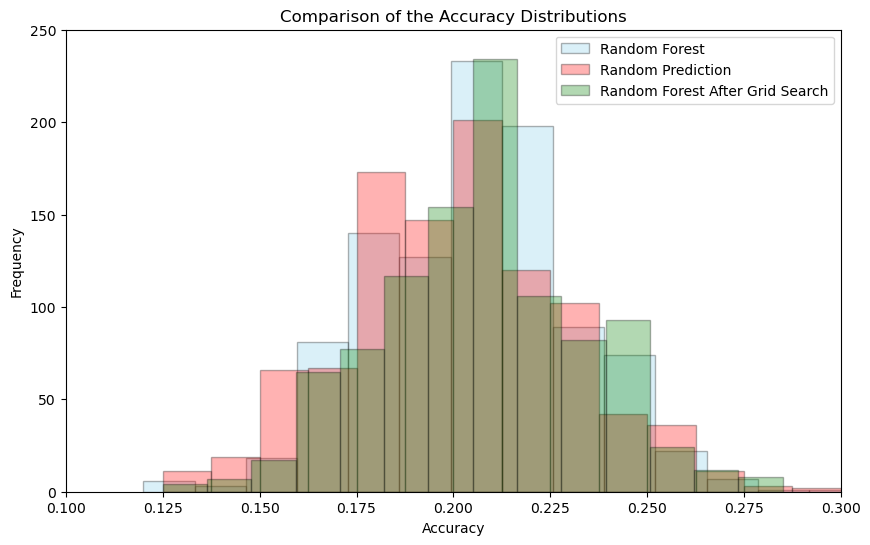

In [286]:
# plot the 3 accuracy distributions
plt.figure(figsize=(10, 6))
plt.hist(accuracy, bins=14, color='skyblue', edgecolor='black', alpha=0.3, label='Random Forest')
plt.hist(accuracy_random, bins=14, color='red', edgecolor='black', alpha=0.3, label='Random Prediction')
plt.hist(accuracy_tuned, bins=14, color='green', edgecolor='black', alpha=0.3, label='Random Forest After Grid Search')
plt.title('Comparison of the Accuracy Distributions')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')

# Set the same scale for x and y axes
plt.xlim([0.1, 0.3])  # Replace min_value and max_value with your desired range for x-axis
plt.ylim([0, 250])  # Replace min_count and max_count with your desired range for y-axis

plt.legend()
plt.show()

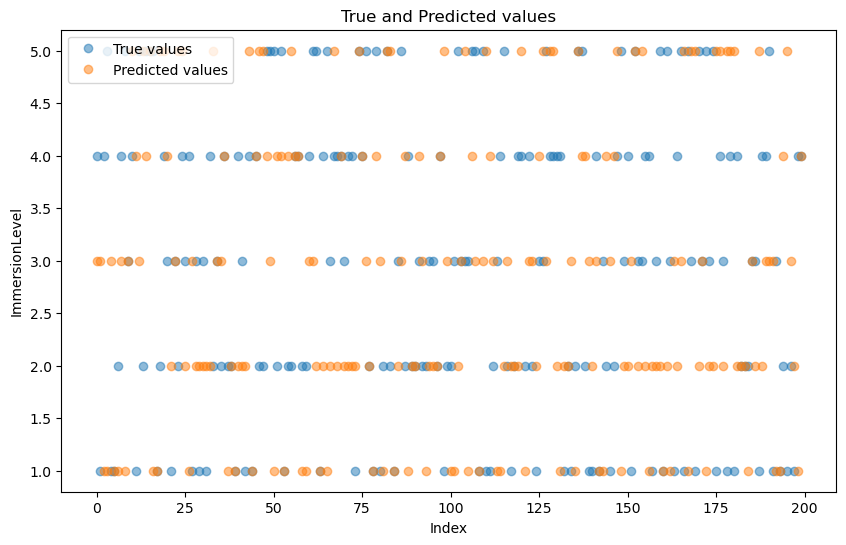

In [279]:
# plot the the predicted and the true values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, 'o', label='True values',alpha=0.5)
plt.plot(y_pred, 'o', label='Predicted values',alpha=0.5)
plt.title('True and Predicted values')
plt.xlabel('Index')
plt.ylabel('ImmersionLevel')
plt.legend()
plt.show()

# CONCLUSIONS OF THE FIRST PART 

## Conclusion

As shown by the distribution of the accuracy graphs, the classification problem has not been successfully solved. The accuracy distribution of the trained models is only slightly better than that of a random predictor. This means that the models do **not** capture the behavior of the dataset correctly. Several factors may be contributing to this issue:

1. **Too small dataset**:
    - The problem is too complex and the models do not have enough data to be caputure patterns.

2. **Sparsity of Immersion Level Data**:
    - The immersion level data is sparse, complicating the model's ability to learn and predict accurately. This sparsity increases the difficulty of identifying clear patterns in the dataset.

## Proposed Solution

To address these challenges, I propose transforming the classification problem into a binary classification task. The objective will be to distinguish between cases of "bad" immersion levels and "good" immersion levels. This simplification could lead to clearer patterns and better model performance.

**Now read the second project "ML_part_2".**